In [1]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LayerNormalization,MaxPool2D
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D, AveragePooling2D, Input, Add
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.utils import to_categorical 
from python_speech_features import mfcc, logfbank
import csv
import os
from keras import layers
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,

In [ ]:
header = 'filename'
for i in range(1, 41):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [ ]:
import python_speech_features
file = open('dataset.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
genres = 'cry no_cry'.split()
for g in genres:
    for filename in os.listdir(f'ba_cry/{g}'):
        songname = f'ba_cry/{g}/{filename}'
        y, sr = librosa.load(songname, mono=True, duration=7)
        mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=40)
#         mfcc = logfbank(y, samplerate=sr, winlen=0.025, winstep=0.01, nfilt=26, nfft=551)
        to_append = f'{filename}'    
        for e in mfcc:
                to_append += f' {np.mean(e)}'
        to_append += f' {g}'
        file = open('dataset.csv', 'a', newline='')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

In [2]:
data = pd.read_csv('dataset.csv')
data = data.drop(['filename'],axis=1)#Encoding the Labels
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)#Scaling the Feature columns
scaler = StandardScaler()
# X =np.array(data.iloc[:, :-1], dtype = float)
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))#Dividing data into training and Testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
model = Sequential()
# model.add(Conv2D(16, (3, 3), activation='relu', strides=(1, 1),padding='same', input_shape=X_train.shape[1]))
# model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1),padding='same')) 
# model.add(Conv2D(64, (3, 3), activation='relu', strides=(1, 1),padding='same'))
# model.add(MaxPool2D ((2, 2)))
# model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(2, activation='softmax'))
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [4]:
model.fit(X_train,y_train,shuffle=True,epochs=50,batch_size=128)

Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.8224 - accuracy: 0.51 - 0s 9ms/step - loss: 0.8224 - accuracy: 0.5189
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.6708 - accuracy: 0.58 - 0s 9ms/step - loss: 0.6708 - accuracy: 0.5849
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.7492 - accuracy: 0.62 - 0s 7ms/step - loss: 0.7492 - accuracy: 0.6226
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.69 - 0s 8ms/step - loss: 0.7164 - accuracy: 0.6981
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.6414 - accuracy: 0.68 - 0s 10ms/step - loss: 0.6414 - accuracy: 0.6887
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.6146 - accuracy: 0.75 - 0s 6ms/step - loss: 0.6146 - accuracy: 0.7547
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 0.5695 - accuracy: 0.71 - 0s 6ms/step - loss: 0.5695 - accuracy: 0.7170
Epoch 8/50
1/1 [=================

In [5]:
import pyaudio
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


AttributeError: module 'librosa' has no attribute 'display'

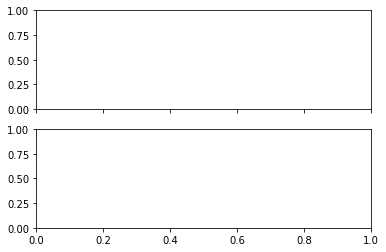

In [6]:
# import librosa.display
y, sr = librosa.load('output2.wav', mono=True, duration=5)
# print(y,sr)
# y.shape
# librosa.display.waveplot(y, sr=22050, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000, ax=None)
librosa.frames_to_time(y, sr=sr)
onset_env = librosa.onset.onset_strength(y, sr=sr,
                                         aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env,
                                       sr=sr)
tempo
hop_length = 512
fig, ax = plt.subplots(nrows=2, sharex=True)
times = librosa.times_like(onset_env, sr=sr, hop_length=hop_length)
M = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=hop_length)
librosa.display.specshow(librosa.power_to_db(M, ref=np.max),
                         y_axis='mel', x_axis='time', hop_length=hop_length,
                         ax=ax[0])
ax[0].label_outer()
ax[0].set(title='Mel spectrogram')
ax[1].plot(times, librosa.util.normalize(onset_env),
         label='Onset strength')
ax[1].vlines(times[beats], 0, 1, alpha=0.5, color='r',
           linestyle='--', label='Beats')
ax[1].legend()
len(beats)

In [ ]:
import librosa.display
y, sr = librosa.load('output3.wav', mono=True, duration=5)
print(y,sr)
y.shape
librosa.display.waveplot(y, sr=22050, max_points=50000.0, x_axis='time', offset=0.0, max_sr=1000, ax=None)

In [8]:
header = 'filename'
for i in range(1, 41):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

In [9]:
file = open('predict.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
y, sr = librosa.load('output.wav', mono=True, duration=5)
mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=40)
# mfcc = logfbank(y, samplerate=sr, winlen=0.025, winstep=0.01, nfilt=26, nfft=551)
to_append = f'output.wav '   
for e in mfcc:
    to_append += f' {np.mean(e)}'
file = open('predict.csv', 'a', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(to_append.split())
live_data = pd.read_csv('predict.csv')
live_data = live_data.drop(['filename'],axis=1)

In [10]:
op=list(to_append.split())
print(op.pop(0))

output.wav


In [11]:
print(op)
Xnew = scaler.transform([op])
print(Xnew)
ynew = model.predict_classes(Xnew)
print("Predicted=%s" % (ynew))
if ynew==0:
    print('Cry')
else:
    print('No cry')

['-469.6595153808594', '92.90167999267578', '20.11655616760254', '3.67458438873291', '4.789157390594482', '18.481462478637695', '11.253288269042969', '14.525856018066406', '7.521642684936523', '11.226836204528809', '1.6245520114898682', '4.196466445922852', '-2.0054752826690674', '6.082876682281494', '2.008265972137451', '7.849215984344482', '2.6197690963745117', '8.932061195373535', '4.19645881652832', '8.454045295715332', '1.820817470550537', '4.892759323120117', '-0.7629687190055847', '4.652968406677246', '0.5349199771881104', '4.013143539428711', '-1.2205383777618408', '3.6790363788604736', '0.6248512864112854', '5.122956275939941', '-1.0149644613265991', '2.7040393352508545', '-0.9766778349876404', '2.998404026031494', '-1.373092770576477', '2.631213665008545', '-0.8575320839881897', '3.389298677444458', '-0.21076714992523193', '2.5591413974761963']
[[-1.09415429  0.85360139  1.50820267  0.02073364  0.87227302  1.21528748
   1.2883153   1.01459596  0.88431852  1.12749174  0.358177

In [ ]:
# Xnew = np.array([live_data.iloc[0][0:25]])
# print(Xnew)
# ynew = model.predict_classes(Xnew)
# print("Predicted=%s" % (ynew))
# if ynew==0:
#     print('Cry')
# else:
#     print('No cry')

In [19]:
import pyaudio
import wave
import pathlib
import threading
import csv
import time

# t1 = threading.Thread(target=print_square, args=(10,))
# t2 = threading.Thread(target=print_cube, args=(10,))

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 44100
RECORD_SECONDS = 5
WAVE_OUTPUT_FILENAME = "output.wav"

stop = 0


p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")


def predict(name):
    #Doing prediction
#     cmap = plt.get_cmap('inferno')
#     plt.figure(figsize=(8,8))
#     pathlib.Path(f'live_data/').mkdir(parents=True, exist_ok=True)
#     # for filename in os.listdir(f'b_cry/{g}'):
    songname = name+'.wav'
#     y, sr = librosa.load(songname, mono=True, duration=7)
#     plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
#     plt.axis('off');
#     plt.savefig(f'live_data/{name}.png')
#     plt.clf()

    header = 'filename '
    for i in range(1, 41):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()

    file = open(f'{name}.csv', 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    # genres = 'discomfort belly_pain burping hungry'.split()
    # for g in genres:
    #     for filename in os.listdir(f'b_cry/{g}'):
    # songname = f'b_cry/{g}/{filename}'
#     songname = f'output.wav'
    y, sr = librosa.load(songname, mono=True, duration=5)
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=40)
    to_append = f'{name}.wav '   
    for e in mfcc:
        to_append += f' {np.mean(e)}'
    # to_append += f' {model.predict(live_data.iloc[0])}'
    #to_append += f' live_data_genre'
    file = open(f'{name}.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split())
    live_data = pd.read_csv(f'{name}.csv')
    live_data = live_data.drop(['filename'],axis=1)

    #print(live_data.iloc[0][0:26])
    op=list(to_append.split())
    op.pop(0)

#     print(Xnew)
    Xnew = scaler.transform([op])
    ynew = model.predict_proba(Xnew)

    print("Predicted=%s" % (ynew))
    if ynew[0][0]>ynew[0][1]:
        print('Cry')
    else:
        print('No cry')


# def record_audio():
for j in range(0,4):
    frames = []
    songname = "output"+str(j)
    WAVE_OUTPUT_FILENAME = "output"+str(j)+".wav"
    print(WAVE_OUTPUT_FILENAME)
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    
    print("Predicting")
#     for i in range(0,5):
#         print(str(i*100))
#         time.sleep(0.5)
    t2 = threading.Thread(target=predict, args=(songname,))
    t2.start()
    
# if __name__ == "__main__":
    # creating thread
# t1 = threading.Thread(target=record_audio, args=())
# t2 = threading.Thread(target=predict, args=())

# while(stop==0):
# t1.start()
# t2.start()
# t1.join()
# t2.join()

# both threads completely executed
print("Done!")

* recording
output0.wav
Predicting
output1.wav
Predicted=[[2.2010505e-04 9.9977988e-01]]
No cry
Predicting
output2.wav
Predicted=[[2.5534546e-05 9.9997449e-01]]
No cry
Predicting
output3.wav
Predicted=[[0.01209235 0.9879076 ]]
No cry
Predicting
Done!
Predicted=[[4.7135867e-08 1.0000000e+00]]
No cry


In [12]:
score = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: {0:.2%}".format(score[1]))
score = model.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: {0:.2%}".format(score[1]))

Training Accuracy: 100.00%
Testing Accuracy: 88.89%


In [ ]:
# from keras.models import load_model
# model.save("ff_nn_v3_Ac88_Be.h5")

In [ ]:
# model.save_weights('ff_nn_v3_Ac88_Be_weights.h5')